In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.graph_objects as go

## Load raw data


In [4]:
hot_obs_npp = pd.read_csv("../data/save/Hot_observed_npp.txt")
hot_obs_npp

,crn,date,stime,etime,itype,depth,l12,d12,
0,#,yymmdd,hhmm,hhmm,,m,mg C/m3,mg C/m3,
1,1,881031,-9,-9,0,24,12.210,-9.000,NaN
2,1,881031,-9,-9,0,42,2.470,0.070,NaN
3,1,881031,-9,-9,0,68,2.580,0.060,NaN
4,1,881031,-9,-9,0,114,0.720,0.160,NaN
...,...,...,...,...,...,...,...,...,...
2151,338,220730,413,1956,2,75,5.600,-9.000,NaN
2152,338,220730,413,1956,2,100,2.427,-9.000,NaN
2153,338,220730,413,1956,2,125,1.833,-9.000,NaN
2154,338,220730,413,1956,2,150,0.450,-9.000,NaN


In [5]:
cafe_npp = xr.open_zarr("../data/1_products/Hot_cafe.zarr")["CAFE"]
cafe_npp.load()

<xarray.DataArray 'CAFE' (time: 1150, latitude: 1, longitude: 1)> Size: 9kB
array([[[294.62574768]],

       [[285.10795593]],

       [[291.46570587]],

       ...,

       [[274.37517166]],

       [[304.28088379]],

       [[292.89963531]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 9kB 1998-01-01 1998-01-09 ... 2022-12-27
Attributes: (12/13)
    adg wavelength:               443nm
    aph wavelength:               443nm
    bbp wavelength:               443nm
    doi:                          10.1002/2016GB005521
    long_name:                    primary_production_using_CAFE_model
    mld_criteria:                 0.125 kg m^-3
    ...                           ...
    reference:                    Silsbe_et_al_2016
    remote_sensing_data_product:  OCCCIv6
    resolution:                   0.00f; // float
    standard_name:                NPP
    units:                        mg m-2 day-1
    weight:                       carbon

In [6]:
cmems_zeu = xr.open_zarr("../data/1_products/Hot_cmems.zarr")["zeu"]
cmems_zeu.load()

<xarray.DataArray 'zeu' (latitude: 1, longitude: 1, time: 9131)> Size: 73kB
array([[[78.18824194, 79.73511748, 78.08560972, ..., 84.16102443,
         85.23599806, 85.5514589 ]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    standard_name:  euphotic_zone_depth
    units:          m

## Formating


In [7]:
# remove last column
hot_obs_npp = hot_obs_npp.iloc[:, :-1]
hot_obs_npp = hot_obs_npp.iloc[1:, :]
hot_obs_npp.columns = ["cruise_number", "time", "start_time", "end_time", "itype", "depth", "l12", "d12"]
hot_obs_npp = hot_obs_npp.drop(columns=["start_time", "end_time", "itype"])
hot_obs_npp

,cruise_number,time,depth,l12,d12
1,1,881031,24,12.210,-9.000
2,1,881031,42,2.470,0.070
3,1,881031,68,2.580,0.060
4,1,881031,114,0.720,0.160
5,3,890108,9,2.005,0.060
...,...,...,...,...,...
2151,338,220730,75,5.600,-9.000
2152,338,220730,100,2.427,-9.000
2153,338,220730,125,1.833,-9.000
2154,338,220730,150,0.450,-9.000


In [8]:
hot_obs_npp = hot_obs_npp.astype(float)
hot_obs_npp = hot_obs_npp.replace(-9, np.nan)
hot_obs_npp

,cruise_number,time,depth,l12,d12
1,1.0,881031.0,24.0,12.210,NaN
2,1.0,881031.0,42.0,2.470,0.07
3,1.0,881031.0,68.0,2.580,0.06
4,1.0,881031.0,114.0,0.720,0.16
5,3.0,890108.0,9.0,2.005,0.06
...,...,...,...,...,...
2151,338.0,220730.0,75.0,5.600,NaN
2152,338.0,220730.0,100.0,2.427,NaN
2153,338.0,220730.0,125.0,1.833,NaN
2154,338.0,220730.0,150.0,0.450,NaN


In [9]:
hot_obs_npp["time"] = hot_obs_npp["time"].astype(int).apply(str).apply(lambda x: x.zfill(6))


def convert_date(date_str):
    year = int(date_str[:2])
    if year >= 88:
        year += 1900
    else:
        year += 2000
    return f"{year}{date_str[2:]}"


# Apply the function to the date column
hot_obs_npp["time"] = hot_obs_npp["time"].apply(convert_date)
hot_obs_npp["time"] = pd.to_datetime(hot_obs_npp["time"], format="%Y%m%d")
hot_obs_npp

,cruise_number,time,depth,l12,d12
1,1.0,1988-10-31,24.0,12.210,NaN
2,1.0,1988-10-31,42.0,2.470,0.07
3,1.0,1988-10-31,68.0,2.580,0.06
4,1.0,1988-10-31,114.0,0.720,0.16
5,3.0,1989-01-08,9.0,2.005,0.06
...,...,...,...,...,...
2151,338.0,2022-07-30,75.0,5.600,NaN
2152,338.0,2022-07-30,100.0,2.427,NaN
2153,338.0,2022-07-30,125.0,1.833,NaN
2154,338.0,2022-07-30,150.0,0.450,NaN


Use the mean of the measurements through the water column.


In [10]:
hot_obs_npp = hot_obs_npp.groupby("time")[["l12", "d12"]].mean()
hot_obs_npp

,l12,d12
time,,
1988-10-31,4.495000,0.096667
1989-01-08,2.010833,0.060000
1989-02-28,2.836667,0.080000
1989-03-27,2.176667,NaN
1989-05-18,3.442500,0.261667
...,...,...
2021-07-17,3.147500,NaN
2021-10-29,3.276250,NaN
2022-03-27,3.386000,NaN


<Axes: xlabel='time'>

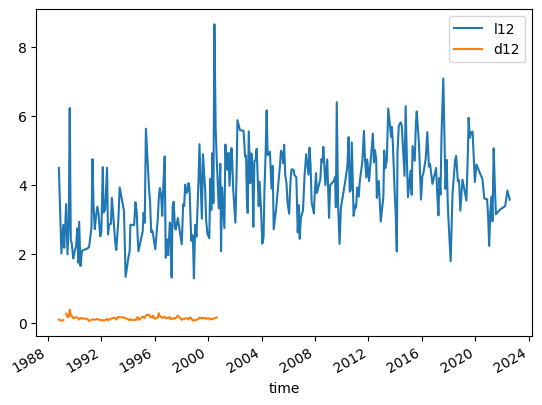

In [11]:
hot_obs_npp.plot()

## Gather CAFE product and in situ data


### Original


In [12]:
cafe_npp = cafe_npp.resample(time="1D").mean().interpolate_na("time")
cafe_npp

<xarray.DataArray 'CAFE' (time: 9127, latitude: 1, longitude: 1)> Size: 73kB
array([[[294.62574768]],

       [[293.43602371]],

       [[292.24629974]],

       ...,

       [[295.74494743]],

       [[294.32229137]],

       [[292.89963531]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-27
Attributes: (12/13)
    adg wavelength:               443nm
    aph wavelength:               443nm
    bbp wavelength:               443nm
    doi:                          10.1002/2016GB005521
    long_name:                    primary_production_using_CAFE_model
    mld_criteria:                 0.125 kg m^-3
    ...                           ...
    reference:                    Silsbe_et_al_2016
    remote_sensing_data_product:  OCCCIv6
    resolution:                   0.00f; // float
    standard_name:                NPP
    units:                        mg m-2 day-1
    weight:                       carbon

In [13]:
cmems_zeu = cmems_zeu.resample(time="1D").mean().interpolate_na("time")
cmems_zeu = cmems_zeu.transpose("time", "latitude", "longitude")
cmems_zeu

<xarray.DataArray 'zeu' (time: 9131, latitude: 1, longitude: 1)> Size: 73kB
array([[[78.18824194]],

       [[79.73511748]],

       [[78.08560972]],

       ...,

       [[84.16102443]],

       [[85.23599806]],

       [[85.5514589 ]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    standard_name:  euphotic_zone_depth
    units:          m

In [14]:
hot_obs_npp_xr = xr.DataArray.from_series(hot_obs_npp["l12"])
hot_obs_npp_xr = hot_obs_npp_xr.resample(time="1D").mean().interpolate_na("time")
hot_obs_npp_xr = hot_obs_npp_xr.expand_dims(
    {"latitude": cafe_npp.latitude, "longitude": cafe_npp.longitude}, axis=[1, 2]
)
hot_obs_npp_xr.time.attrs = {"axis": "T", **cafe_npp.time.attrs}
hot_obs_npp_xr = hot_obs_npp_xr * cmems_zeu
hot_obs_npp_xr.attrs = {
    "units": "mg m-2 day-1",
    "type": "in situ",
    "station": "hot",
    "desc": "L12 multiplied by ZEU (from CMEMS)",
}
hot_obs_npp_xr

<xarray.DataArray (time: 8977, latitude: 1, longitude: 1)> Size: 72kB
array([[[183.4949276 ]],

       [[186.56237688]],

       [[182.15172717]],

       ...,

       [[327.72457179]],

       [[326.50529436]],

       [[334.47255167]]])
Coordinates:
  * time       (time) datetime64[ns] 72kB 1998-01-01 1998-01-02 ... 2022-07-30
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
Attributes:
    units:    mg m-2 day-1
    type:     in situ
    station:  hot
    desc:     L12 multiplied by ZEU (from CMEMS)

### Lowess filtering


In [15]:
def lowess_smooth(data, frac) -> xr.DataArray:
    result = lowess(
        data.data.flatten(),
        data.time.data,
        frac=frac,
        it=0,
        delta=0.0,
        is_sorted=False,
        return_sorted=False,
        missing="drop",
    )

    return xr.DataArray(
        result.reshape(data.shape),
        dims=["time", "latitude", "longitude"],
        coords={"time": data.time, "latitude": cafe_npp.latitude, "longitude": cafe_npp.longitude},
        name="l12_lowess_0.1",
        attrs={
            "units": "mg m-2 day-1",
            "type": "in situ",
            "description": "Lowess smoothed : L12 x ZEU",
            "lowess_frac": frac,
            "station": "hot",
        },
    )

In [16]:
lowess_smoothed_2 = lowess_smooth(hot_obs_npp_xr, 0.02)
lowess_smoothed_5 = lowess_smooth(hot_obs_npp_xr, 0.05)
lowess_smoothed_10 = lowess_smooth(hot_obs_npp_xr, 0.10)

hot_obs_npp_xr_product = xr.Dataset(
    {
        "l12": hot_obs_npp_xr,
        "l12_lowess_2": lowess_smoothed_2,
        "l12_lowess_5": lowess_smoothed_5,
        "l12_lowess_10": lowess_smoothed_10,
    },
    coords={"time": hot_obs_npp_xr.time, "latitude": cafe_npp.latitude, "longitude": cafe_npp.longitude},
)
hot_obs_npp_xr_product

<xarray.Dataset> Size: 359kB
Dimensions:        (time: 8977, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 72kB 1998-01-01 ... 2022-07-30
  * latitude       (latitude) float64 8B 22.75
  * longitude      (longitude) int64 8B -158
Data variables:
    l12            (time, latitude, longitude) float64 72kB 183.5 ... 334.5
    l12_lowess_2   (time, latitude, longitude) float64 72kB 189.3 ... 335.5
    l12_lowess_5   (time, latitude, longitude) float64 72kB 278.1 ... 345.3
    l12_lowess_10  (time, latitude, longitude) float64 72kB 261.0 ... 321.8

## Plotting


In [17]:
# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(go.Scatter(x=cafe_npp["time"].values, y=cafe_npp.data.flatten(), mode="lines", name="CAFE NPP"))

# Create traces

for var in ["l12", "l12_lowess_2", "l12_lowess_5", "l12_lowess_10"]:
    trace = go.Scatter(
        x=hot_obs_npp_xr_product["time"].values, y=hot_obs_npp_xr_product[var].data.flatten(), mode="lines", name=var
    )
    fig.add_trace(trace)


# Update layout
fig.update_layout(title="CAFE NPP and Observed NPP", xaxis_title="Date", yaxis_title="NPP")

# Show the figure
fig.show()

The annual cycle is only visible with the lowess 2% filtering.


## Export


In [18]:
hot_obs_npp_xr_product

<xarray.Dataset> Size: 359kB
Dimensions:        (time: 8977, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 72kB 1998-01-01 ... 2022-07-30
  * latitude       (latitude) float64 8B 22.75
  * longitude      (longitude) int64 8B -158
Data variables:
    l12            (time, latitude, longitude) float64 72kB 183.5 ... 334.5
    l12_lowess_2   (time, latitude, longitude) float64 72kB 189.3 ... 335.5
    l12_lowess_5   (time, latitude, longitude) float64 72kB 278.1 ... 345.3
    l12_lowess_10  (time, latitude, longitude) float64 72kB 261.0 ... 321.8

In [20]:
hot_obs_npp_xr_product.to_zarr("../data/1_products/Hot_observed_npp.zarr", mode="w")